# Predict POS with an HMM

```yaml
Course:   DS 5001
Module:   04 Lab
Topic:    Predict POS with an HMM
Author:   R.C. Alvarado
Date:     14 February 2022 (revised and improved)
```

**Purpose**: Demonstrate Hidden Markov Model applied to POS detection, including the Viterbi algorithm by hand. 

# Set Up

In [1]:
import pandas as pd
import numpy as np
import nltk
import re

In [2]:
import configparser

In [3]:
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [4]:
data_prefix = 'austen-melville'

In [5]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
SENT = OHCO[:4]
colors = "YlGnBu"

# Get Annotated `TOKEN` Table

We use the `CORPUS` table from our previous exercise.

In [6]:
TOKEN = pd.read_csv(f"{output_dir}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [7]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     24       0        6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  
book_id chap_id para_num sent_num token_num            
105     1       1        0        0                NN  
                                  1                NN  
                                  2                NN  
                                  3                IN  
                                  4                NN  
...                                               ...  
34970   114     24       0        6                DT  
                                  7                NN  
                                  8                IN  
                                  9                NN  
                                  10               NN  

[2059272 rows x 5 columns]

# Create Table of POS Tags 

We create a table rrom the Penn Treebank Project list of part-of-speech tags.

## Grab UPenn Codes

We get a text version of the UPenn Codes, or tag set, by calling `nltk.help.upenn_tagset()`. The extra information can be used later in visualizations, etc.

In [8]:
POS = pd.read_csv(f'{data_home}/misc/upenn_tagset.txt', sep='\t', names=['pos_code','def'])
POS = POS[POS.pos_code.str.match(r'^\w')].set_index('pos_code') # Keep only letter codes

In [9]:
POS

def
pos_code                                               
CC                            conjunction, coordinating
CD                                    numeral, cardinal
DT                                           determiner
EX                                    existential there
FW                                         foreign word
IN            preposition or conjunction, subordinating
JJ                        adjective or numeral, ordinal
JJR                              adjective, comparative
JJS                              adjective, superlative
LS                                     list item marker
MD                                      modal auxiliary
NN                       noun, common, singular or mass
NNP                              noun, proper, singular
NNPS                               noun, proper, plural
NNS                                noun, common, plural
PDT                                      pre-determiner
POS                                     genitive marker
PRP                                   pronoun, personal
PRP$                                pronoun, possessive
RB                                               adverb
RBR                                 adverb, comparative
RBS                                 adverb, superlative
RP                                             particle
SYM                                              symbol
TO             "to" as preposition or infinitive marker
UH                                         interjection
VB                                      verb, base form
VBD                                    verb, past tense
VBG                  verb, present participle or gerund
VBN                               verb, past participle
VBP        verb, present tense, not 3rd person singular
VBZ            verb, present tense, 3rd person singular
WDT                                       WH-determiner
WP                                           WH-pronoun
WP$                              WH-pronoun, possessive
WRB                                           Wh-adverb

## Add value counts

In [10]:
POS['n'] = TOKEN.pos.value_counts().to_frame().sort_index()
POS['n'] = POS['n'].fillna(0).astype('int')

In [11]:
POS.sort_values('n', ascending=False)

def       n
pos_code                                                       
NN                       noun, common, singular or mass  383979
IN            preposition or conjunction, subordinating  264122
DT                                           determiner  204813
JJ                        adjective or numeral, ordinal  155152
PRP                                   pronoun, personal  117186
RB                                               adverb  113500
VBD                                    verb, past tense  104096
NNP                              noun, proper, singular   97366
VB                                      verb, base form   90361
CC                            conjunction, coordinating   83450
PRP$                                pronoun, possessive   59075
NNS                                noun, common, plural   58630
TO             "to" as preposition or infinitive marker   55581
VBN                               verb, past participle   51108
VBG                  verb, present participle or gerund   41914
VBP        verb, present tense, not 3rd person singular   40009
MD                                      modal auxiliary   31876
VBZ            verb, present tense, 3rd person singular   29391
CD                                    numeral, cardinal   12610
WDT                                       WH-determiner   11000
WP                                           WH-pronoun    9930
WRB                                           Wh-adverb    9757
RP                                             particle    7897
JJR                              adjective, comparative    5268
JJS                              adjective, superlative    4710
PDT                                      pre-determiner    4686
EX                                    existential there    3776
RBR                                 adverb, comparative    3360
RBS                                 adverb, superlative    2199
WP$                              WH-pronoun, possessive     842
FW                                         foreign word     490
NNPS                               noun, proper, plural     415
POS                                     genitive marker     332
UH                                         interjection      74
LS                                     list item marker       3
SYM                                              symbol       0

## Create `POS_GROUP` table

We want a simplified list of grammatical categories. We use the first two letters of each code name as our group.

In [12]:
# Add pos_group feature to POS and TOKEN
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
# TOKEN['pos_group'] = TOKEN.pos.str[:2]

In [13]:
# Generate new table from it
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [14]:
POS_GROUP.sort_values('i').style.background_gradient(cmap=colors)

## Save

In [15]:
POS.to_csv(f"{output_dir}/{data_prefix}-POS.csv")
POS_GROUP.to_csv(f"{output_dir}/{data_prefix}-POS_GROUP.csv")

# Extract Model from `TOKEN`

In [16]:
TOKEN = TOKEN.join(POS, on="pos_group", rsuffix='_y').dropna()

In [17]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     24       0        6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     24       0        6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  \
book_id chap_id para_num sent_num token_num             
105     1       1        0        0                NN   
                                  1                NN   
                                  2                NN   
                                  3                IN   
                                  4                NN   
...                                               ...   
34970   114     24       0        6                DT   
                                  7                NN   
                                  8                IN   
                                  9                NN   
                                  10               NN   

                                                                                    def  \
book_id chap_id para_num sent_num token_num                                               
105     1       1        0        0                      noun, common, singular or mass   
                                  1                      noun, common, singular or mass   
                                  2                      noun, common, singular or mass   
                                  3           preposition or conjunction, subordinating   
                                  4                      noun, common, singular or mass   
...                                                                                 ...   
34970   114     24       0        6                                          determiner   
                                  7                      noun, common, singular or mass   
                                  8           preposition or conjunction, subordinating   
                                  9                      noun, common, singular or mass   
                                  10                     noun, common, singular or mass   

                                                    n pos_group_y  
book_id chap_id para_num sent_num token_num                        
105     1       1        0      

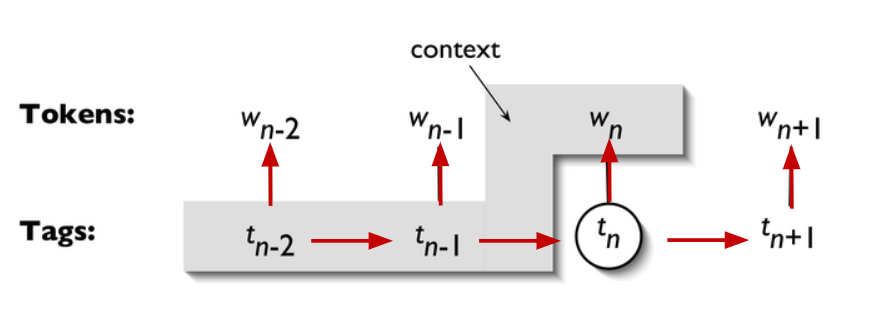
<img src="images/hmm.png" width="750">

## Create Table of $t_n \rightarrow t_{n+1}$ Transissions ($A$)

**Add sentence boundaries to sequence**

Note that we are breaking our data by adding `<s>` as a key, although 
it is not part of the UPenn tagset. We might consider creating a code 
for sentence beginnings or endings, such as the stop tag in Eistenstein 2019.

In [67]:
A = TOKEN[['pos_group']].join(TOKEN[['pos_group']].shift(-1), lsuffix='_x', rsuffix="_y")\
    .value_counts().to_frame('n').sort_index()

In [68]:
A['cp'] = A.n / A.groupby('pos_group_x').n.sum()  # P(y|x)

In [69]:
A

n        cp
pos_group_x pos_group_y                
CC          CC            117  0.001402
            CD           1162  0.013925
            DT           9585  0.114859
            EX            442  0.005297
            FW              1  0.000012
...                       ...       ...
WP          MD           1161  0.107779
            NN           1521  0.141199
            RB            525  0.048737
            TO            119  0.011047
            VB           5872  0.545117

[205 rows x 2 columns]

In [70]:
AM = A.cp.unstack(fill_value=0)

In [71]:
AM.style.background_gradient(axis=None, cmap=colors)

## Sanity Tests

In [84]:
AM.sum(1)

pos_group_x
CC    1.0
CD    1.0
DT    1.0
EX    1.0
FW    1.0
IN    1.0
JJ    1.0
LS    1.0
MD    1.0
NN    1.0
RB    1.0
RP    1.0
TO    1.0
UH    1.0
VB    1.0
WP    1.0
dtype: float64

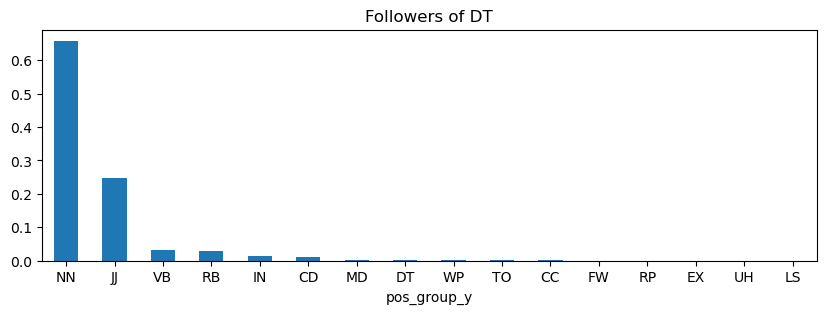

In [116]:
AM.loc['DT'].sort_values(ascending=False).plot.bar(rot=0, title="Followers of DT", figsize=(10,3));

## Create Table of Initial State Probabilities $\Pi$

We get counts of pos tags that appear at the beginnings of sentences. 

Note: since
we took the trouble to create an OHCO index, we don't need to add `<s>` markers
to find out these frequencies.

On the other hand, if we have pads in our Emission table, then we wouldn't need to creat this table at all.

In [86]:
PI = TOKEN.query("token_num == 0").pos_group.value_counts().to_frame('n').sort_index()
PI.index.name = 'pos_group'
PI['cp'] = PI.n / PI.n.sum()

In [87]:
PI

n        cp
pos_group                 
CC          7864  0.107065
CD           743  0.010116
DT          9868  0.134348
EX           917  0.012485
FW             8  0.000109
IN         10245  0.139481
JJ          4384  0.059686
LS             3  0.000041
MD           418  0.005691
NN         25610  0.348668
RB          5347  0.072797
TO           745  0.010143
UH            50  0.000681
VB          6309  0.085894
WP           940  0.012798

## Make sure $\Pi $ shares sample space with $A$ and $B$

Find out what is missing from PI.\
This will be important below.

In [88]:
for tag in (set(AM.index) - set(PI.index)):
    print(tag)
    PI.loc[tag, ['n', 'cp']] = (0, 0)

RP


In [89]:
PI

n        cp
pos_group                   
CC          7864.0  0.107065
CD           743.0  0.010116
DT          9868.0  0.134348
EX           917.0  0.012485
FW             8.0  0.000109
IN         10245.0  0.139481
JJ          4384.0  0.059686
LS             3.0  0.000041
MD           418.0  0.005691
NN         25610.0  0.348668
RB          5347.0  0.072797
TO           745.0  0.010143
UH            50.0  0.000681
VB          6309.0  0.085894
WP           940.0  0.012798
RP             0.0  0.000000

## Sanity Test

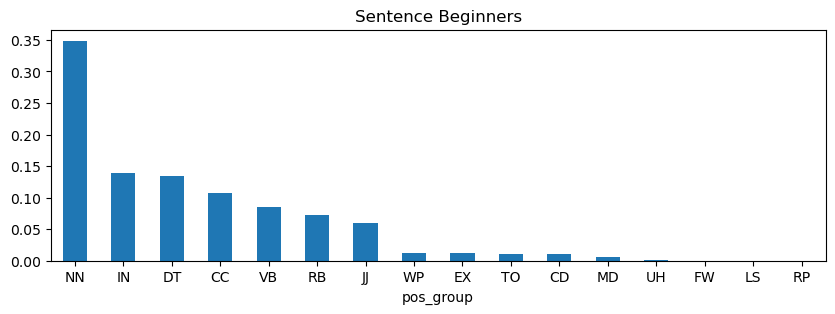

In [115]:
PI.sort_values('cp', ascending=False).cp.plot.bar(rot=0, title="Sentence Beginners", figsize=(10,3));

## Create Table of $t_n \rightarrow o_n$ Emissions ($ B $)

In [95]:
B = TOKEN[['pos_group', 'term_str']].value_counts().to_frame('n').sort_index()
B.index.names = ['pos_group_y', 'term_str']
B['cp'] = B.n / B.groupby('pos_group_y').n.sum()

In [96]:
B.head()

n        cp
pos_group_y term_str                   
CC          acquired        1  0.000012
            ah              1  0.000012
            all             2  0.000024
            altogether      3  0.000036
            and         60705  0.727442

In [31]:
BM = B.cp.unstack(fill_value=0)

In [32]:
BM

term_str            0         1        10       100      1000     10000  \
pos_group_y                                                               
CC           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
CD           0.000159  0.001348  0.000476  0.000159  0.000159  0.000238   
DT           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
EX           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
FW           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
IN           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
JJ           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LS           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
MD           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NN           0.000000  0.000011  0.000000  0.000000  0.000000  0.000000   
RB           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
RP           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TO           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
UH           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
VB           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
WP           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

term_str     10000000     10440     10800      10th  ...  zoroaster      zozo  \
pos_group_y                                          ...                        
CC           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
CD           0.000079  0.000079  0.000159  0.000079  ...   0.000000  0.000000   
DT           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
EX           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
FW           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
IN           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
JJ           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
LS           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
MD           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
NN           0.000000  0.000000  0.000000  0.000002  ...   0.000004  0.000000   
RB           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
RP           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
TO           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
UH           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   
VB           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000003   
WP           0.000000  0.000000  0.000000  0.000000  ...   0.000000  0.000000   

term_str         zuma       zur         à     æneas     æniad      æson  \
pos_group_y                                                               
CC           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
CD           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
DT           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
EX           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
FW           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
IN           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
JJ           0.000000  0.000000  0.000006  0.000000  0.000000  0.000000   
LS           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
MD           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NN           0.000015  0.000004  0.000007  0.000002  0.000002  0.000004   
RB           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
RP           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TO           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
UH           0.000000  0.000000  0.000000  0.000000  0.000000  0.

## Sanity Tests

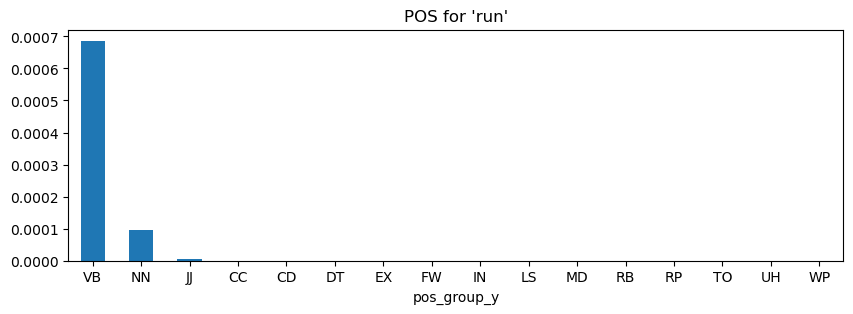

In [112]:
BM["run"].sort_values(ascending=False).plot.bar(rot=0, title="POS for 'run'", figsize=(10,3));

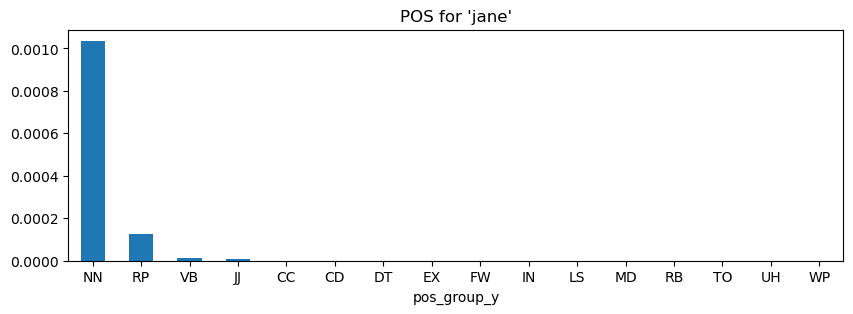

In [113]:
BM["jane"].sort_values(ascending=False).plot.bar(rot=0, title="POS for 'jane'", figsize=(10,3));

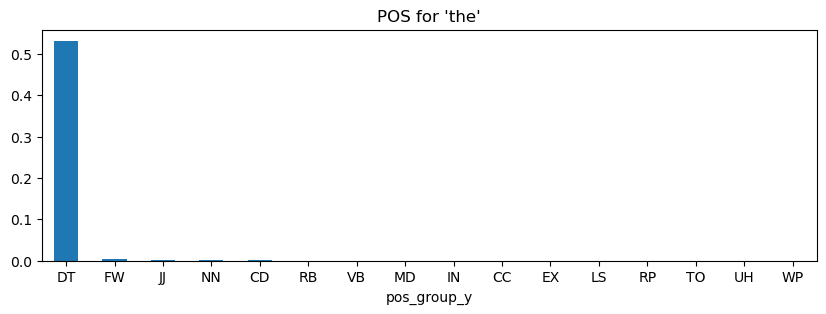

In [114]:
BM["the"].sort_values(ascending=False).plot.bar(rot=0, title="POS for 'the'", figsize=(10,3));

## Put into single model `HMM`

For convenience, bind the tables into signle model table.

Note that a model can be represented as a dataframe.

In [117]:
HMM = pd.concat([AM, PI.cp, BM], keys=['trans','start','emit'], axis=1)

# Prepare Test Data

Import file of raw test sentences.

In [122]:
test_sentences = [s.strip() for s in open(f"{data_home}/misc/test_sentences.txt").readlines()]

Create dataframe of sentences. We will add features here later.

In [123]:
TEST_SENTENCES = pd.DataFrame({'sent_str':test_sentences})
TEST_SENTENCES.index.name = 'sent_id'

In [124]:
TEST_SENTENCES.head()

sent_str
sent_id                                                   
0            the quick brown fox jumped over the lazy dogs
1        The event had every promise of happiness for h...
2        Mr Weston was a man of unexceptionable charact...
3                but it was a black morning's work for her
4        The want of Miss Taylor would be felt every ho...

Convert sentences to tokens (and terms).

In [125]:
TEST_TOKENS = TEST_SENTENCES.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
TEST_TOKENS.index.names = ['sent_id', 'token_num']
TEST_TOKENS['term_str'] = TEST_TOKENS.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()

In [126]:
TEST_TOKENS.head()

token_str term_str
sent_id token_num                   
0       0               the      the
        1             quick    quick
        2             brown    brown
        3               fox      fox
        4            jumped   jumped

# The Viterbi Algorithm

The Vertibi implements the optimization function ...

<img src="images/formula.png" width="400">

... by means of this procedure: 
<img src="images/viterbi.png" width="750">

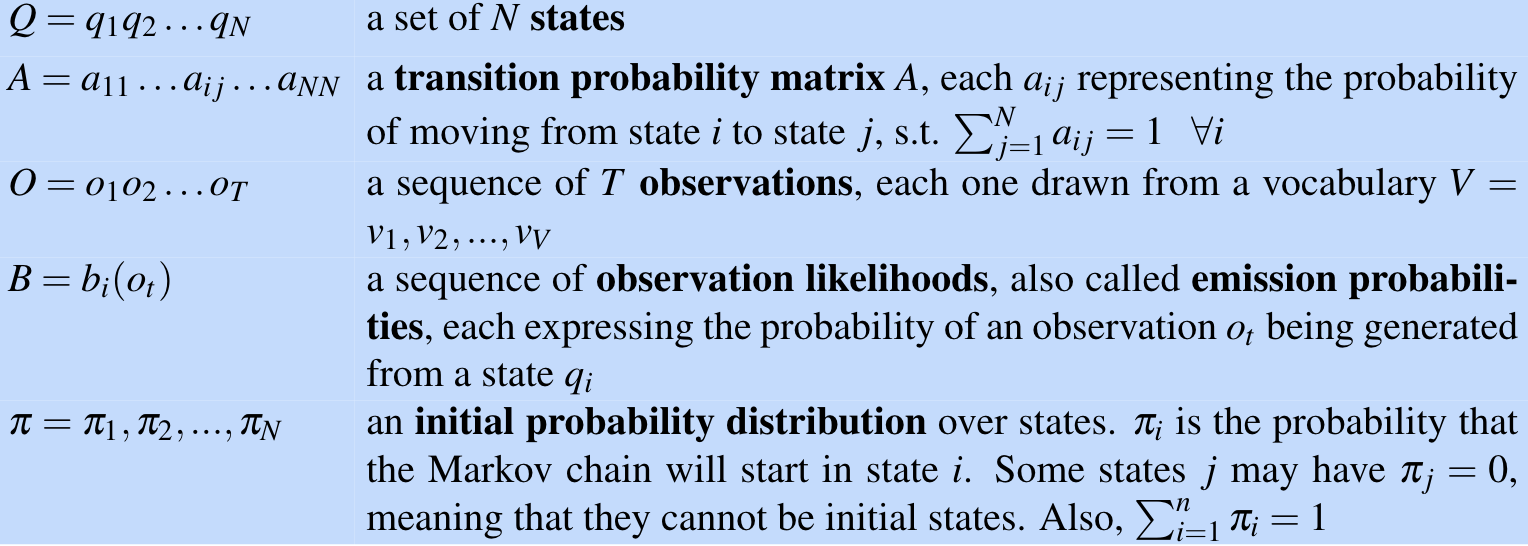

**Translation to NLP use case**:

$Q \rightarrow$ A set of $N$ POS tags.\
$O \rightarrow$ A sequence of $T$ tokens that compose a sentence.\
$A \rightarrow$ POS to POS table $P(q_i|q_{i-1})$.\
$B \rightarrow$ POS to word table $P(w_i|q_i)$.\
$\Pi  \rightarrow$ Probabilites of POS as tag for first token.

In [40]:
# HMM.trans

## Define function

In [143]:
def viterbi(obs, HMM):
    
    # Import model
    states = HMM.index.to_list()
    start_prob = HMM.start.cp
    trans_prob = HMM.trans
    emit_prob = HMM.emit
    
    # Set up Viterbi lattice
    V = pd.DataFrame(np.zeros((len(states), len(obs))), 
                     columns=range(len(obs)), 
                     index=states)
        
    # Initialize the first observation
    V[0] = start_prob * emit_prob[obs[0]]
    
    # Iterate over the remaining observations
    for t, o in enumerate(obs[1:], start=1):
        
        # Simple method -- works OK
        # V[t] = trans_probs[V[t-1].idxmax()] * emit_probs[o]
        
        for s in states:
            try:
                V.loc[s, t] = (V[t-1] * trans_prob[s] * emit_prob.loc[s, o]).max()
            except KeyError:
                V.loc[s, t] = (V[t-1] * trans_prob[s]).max() # Fallback of word is OOV


    return V

* `obs` is a list representing the sequence of observed events $O$ 
* `states` is a list of the hidden states $Q$
* `start_prob` is a pandas Series representing the probability distribution over the states at time 0 $\Pi$
* `trans_prob` is a pandas DataFrame representing the transition probability matrix $A$
* `emit_prob` is a pandas DataFrame representing the emission probability matrix $B$

The function returns a data frame of the Viterbi lattice, which can be used to compute most likely sequence of hidden states that generated the observed events.

## Test with one sentence

In [144]:
test_observations = TEST_TOKENS.loc[TEST_SENTENCES.sample().index[0]].term_str.to_list()

In [145]:
V = viterbi(test_observations, HMM)

In [146]:
pd.concat([pd.Series(test_observations), V.idxmax()], keys=['obs', 'tag'], axis=1).T

0    1    2   3      4       5   6          7     8             9   \
obs  she  was  now  in  great  danger  of  suffering  from  intellectual   
tag   NN   VB   RB  IN     JJ      NN  IN         NN    IN            JJ   

           10  
obs  solitude  
tag        NN

In [45]:
for w, k in zip(test_observations, V.idxmax().values):
    print(f"{w}/{k}", end=' ')

she/NN dearly/RB loved/VB her/NN father/NN 

## Diminishing probabilities

Note diminishing probabilities in the lattice.

In [46]:
V.style.background_gradient(cmap=colors, axis=0)

Try L1 normalization by column.

In [47]:
VNORM = (V / V.sum()) 

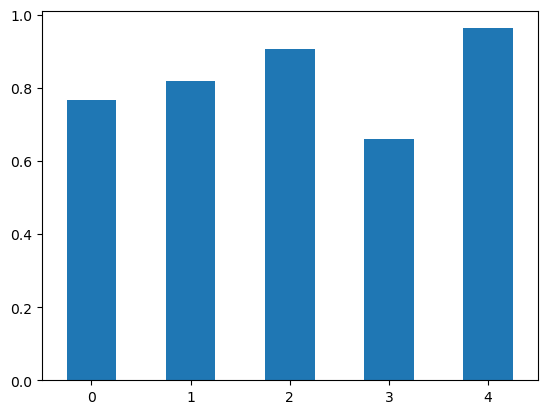

In [48]:
VNORM.max().plot.bar(rot=0);

In [49]:
VNORM.style.background_gradient(cmap=colors)

In [50]:
# VNORMI = -np.log2(VNORM)
# VNORMI
# pd.concat([VNORMI.idxmin(), VNORMI.min()], axis=1, keys=['pos','i']).T

# ETA Version

This version uses Pandas, but assumes that data are stored in F2 compliant dataframes, i.e. there is TOKENS table.

All of the resulting data are put where they belong in the model.

## Define the function

In [51]:
def viterbi_eta(sent_tokens, verbose=True):
    """
    - _sent_tokens_ must be a selection from an F1 TOKENS table
    """
    
    # Assumes HMM is in scope
    
    # Import model
    TAGS = HMM.index.to_list()
    PI = HMM.start.cp
    AM = HMM.trans
    BM = HMM.emit
    
    # Extract basic data
    ohco = sent_tokens.index.names # Save for return 
    TOKENS = sent_tokens.reset_index() # Reset index so we can access term_str as a column

    # Define dataframes    
    LATTICE = pd.DataFrame(np.zeros((len(TAGS), len(TOKENS)), 
                dtype='float'), index=TAGS, columns=TOKENS.token_num) 
    LATTICE.index.name = 'pos_group'
    
    # Handle first word (NB: fallback net yet implemented)
    first_word = TOKENS.loc[0].term_str
    LATTICE[0] = PI * BM[first_word]

    # Predict the rest of the sentence
    for t in range(1, len(TOKENS)): # Offset of token
        word = TOKENS.loc[t].term_str
        for s in TAGS: # tag name
            if word not in BM.columns:
                b = 1/len(TAGS) # Fallback probability = equiprobable
            else:
                b = BM.loc[s, word]
            LATTICE.loc[s, t] = (LATTICE[t-1] * AM[s] * b).max()

    # Compute results (no need for backpointer, etc.) and bind to TOKENS
    # LATTICE = LATTICE / LATTICE.sum() # Normalize diminishing probs
    TOKENS['tag'] = LATTICE.idxmax()
    TOKENS['prob'] = LATTICE.max()
    TOKENS['i'] = np.log2(1/TOKENS.prob)
    
    if verbose:
        pp = 2**TOKENS.i.mean().round()
        print(" ".join((TOKENS.term_str + '/' + TOKENS.tag).values), f"({pp})")
    
    # Add index back and return
    TOKENS = TOKENS.set_index(ohco)
    return TOKENS

## Try wiith one sentence

In [52]:
x = TEST_SENTENCES.sample().index[0]
# x = 41
X2 = viterbi_eta(TEST_TOKENS.loc[x])

the/DT want/NN of/IN miss/NN taylor/NN would/MD be/VB felt/VB every/DT hour/NN of/IN every/DT day/NN (2.8823037615171174e+17)


In [53]:
X2

token_str term_str tag          prob           i
token_num                                                 
0               The      the  DT  7.143544e-02    3.807216
1              want     want  NN  1.931197e-05   15.660145
2                of       of  IN  1.211555e-06   19.654709
3              Miss     miss  NN  1.353134e-09   29.461048
4            Taylor   taylor  NN  2.416773e-14   45.233911
5             would    would  MD  1.596277e-16   52.476138
6                be       be  VB  4.714484e-18   57.557606
7              felt     felt  VB  1.866506e-21   68.860150
8             every    every  DT  4.050495e-24   77.708176
9              hour     hour  NN  3.137076e-27   88.042638
10               of       of  IN  1.968074e-28   92.037202
11            every    every  DT  1.010458e-30   99.642834
12              day      day  NN  2.390841e-33  108.366109

## Try with all sentences

In [54]:
TEST = TEST_TOKENS.groupby('sent_id', group_keys=False).apply(lambda x: viterbi_eta(x, False))

In [55]:
sample_sentence_id = TEST_SENTENCES.sample().index[0]

In [56]:
sample_sentence_id

6

In [57]:
TEST.loc[sample_sentence_id]

token_str term_str tag          prob           i
token_num                                                 
0               how      how  NN  1.787296e-04   12.449934
1               she      she  NN  2.426079e-08   25.296798
2               had      had  VB  2.028793e-10   32.198659
3            taught   taught  VB  6.026281e-15   47.237653
4               and      and  CC  1.084767e-16   53.033464
5               how      how  NN  1.380186e-20   65.973699
6               she      she  NN  1.873468e-24   78.820563
7               had      had  VB  1.566676e-26   85.722424
8            played   played  VB  4.853058e-31  100.700877
9              with     with  IN  5.812543e-33  107.084458
10              her      her  NN  6.246747e-36  116.946306
11             from     from  IN  5.701365e-38  123.721960
12             five     five  CD  2.645267e-41  134.795639
13            years    years  NN  1.852821e-44  145.275113
14              old      old  JJ  6.719805e-48  156.704129

## What POS tags are hardest to predict?

First, create a dataframe for predict POS tags.

In [58]:
TEST_POS = TEST.groupby('tag').i.mean().to_frame('mean_i')

In [59]:
TEST_POS_IDX = TEST_POS.index
TEST_POS = TEST_POS.merge(POS_GROUP, left_on='tag', right_on='pos_group').set_index(TEST_POS_IDX)
del(TEST_POS_IDX)
TEST_POS['label'] = TEST_POS.index + ' /' + TEST_POS['def'].str.split(r'[,;]').str[0]

In [60]:
TEST_POS

mean_i       n                                                def  \
tag                                                                         
CC   39.029957   83450                          conjunction, coordinating   
CD   64.896209   12610                                  numeral, cardinal   
DT   44.353783  204813                                         determiner   
IN   60.731823  264122          preposition or conjunction, subordinating   
JJ   63.466502  165130   adjective or numeral, ordinal;  adjective, co...   
MD   54.594164   31876                                    modal auxiliary   
NN   63.901895  540390   noun, common, singular or mass;  noun, proper...   
RB   55.894656  119059   adverb;  adverb, comparative;  adverb, superl...   
TO   45.960652   55581           "to" as preposition or infinitive marker   
VB   52.840035  356879   verb, base form;  verb, past tense;  verb, pr...   
WP   18.723592   10772                WH-pronoun;  WH-pronoun, possessive   

            p         i         h  \
tag                                 
CC   0.040530  4.624859  0.187446   
CD   0.006124  7.351202  0.045022   
DT   0.099474  3.329535  0.331203   
IN   0.128279  2.962638  0.380046   
JJ   0.080201  3.640240  0.291950   
MD   0.015482  6.013300  0.093096   
NN   0.262458  1.929842  0.506502   
RB   0.057825  4.112166  0.237785   
TO   0.026995  5.211179  0.140674   
VB   0.173330  2.528407  0.438249   
WP   0.005232  7.578484  0.039649   

                                             label  
tag                                                 
CC                                CC / conjunction  
CD                                    CD / numeral  
DT                                 DT / determiner  
IN                 IN / preposition or conjunction  
JJ                       JJ / adjective or numeral  
MD                            MD / modal auxiliary  
NN                                       NN / noun  
RB                                     RB / adverb  
TO   TO / "to" as preposition or infinitive marker  
VB                                       VB / verb  
WP                                 WP / WH-pronoun

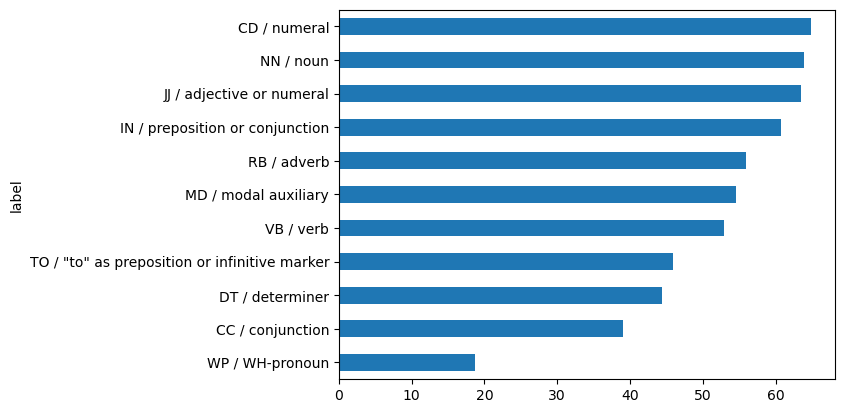

In [61]:
TEST_POS.reset_index().set_index('label').mean_i.sort_values().plot.barh();

## Add features to sentences

In [62]:
TEST['code'] = TEST.apply(lambda x: x.term_str + '/' + x.tag, axis=1) 
TEST_SENTENCES['code'] = TEST.groupby('sent_id').apply(lambda x: ' '.join(x.code))
TEST_SENTENCES['i_mean'] = TEST.groupby('sent_id').i.mean().round(2)
TEST_SENTENCES['pp'] = np.exp2(TEST_SENTENCES.i_mean)

In [63]:
TEST_SENTENCES.sort_values('pp')

sent_str  \
sent_id                                                      
23                          and a Miss Taylor in the house   
10             but the intercourse of the last seven years   
15                          interested in all its concerns   
27                         but he was no companion for her   
30                  and Mr Woodhouse had not married early   
22                              only half a mile from them   
33                        without activity of mind or body   
24        and with all her advantages natural and domestic   
19                          How was she to bear the change   
14                      knowing all the ways of the family   
26                             She dearly loved her father   
3                but it was a black morning's work for her   
29          The evil of the actual disparity in their ages   
9                 A large debt of gratitude was owing here   
32           for having been a valetudinarian all his life   
31       was much increased by his constitution and habits   
1        The event had every promise of happiness for h...   
28       He could not meet her in conversation rational...   
13       She had been a friend and companion such as fe...   
34           he was a much older man in ways than in years   
25       she was now in great danger of suffering from ...   
37       Her sister though comparatively but little rem...   
18       and who had such an affection for her as could...   
17       one to whom she could speak every thought as i...   
0            the quick brown fox jumped over the lazy dogs   
8        and how nursed her through the various illness...   
36       his talents could not have recommended him at ...   
4        The want of Miss Taylor would be felt every ho...   
40       before Christmas brought the next visit from I...   
16       and peculiarly interested in herself in every ...   
21       but Emma was aware that great must be the diff...   
11       the equal footing and perfect unreserve which ...   
20       It was true that her friend was going only hal...   
39       and many a long October and November evening m...   
12       on their being left to each other was yet a de...   
41       and their little children to fill the house an...   
35       and though everywhere beloved for the friendli...   
5        She recalled her past kindness the kindness th...   
2        Mr Weston was a man of unexceptionable charact...   
7        how she had devoted all her powers to attach a...   
38       being settled in London only sixteen miles off...   
6        how she had taught and how she had played with...   

                                                      code  i_mean  \
sent_id                                                              
23       and/CC a/DT miss/NN taylor/NN in/IN the/DT hou...   27.62   
10       but/CC the/DT intercourse/NN of/IN the/DT last...   30.88   
15           interested/JJ in/IN all/DT its/NN concerns/NN   32.14   
27       but/CC he/NN was/VB no/DT companion/NN for/IN ...   32.69   
30       and/CC mr/NN woodhouse/NN had/VB not/RB marrie...   33.02   
22            only/RB half/JJ a/DT mile/NN from/IN them/NN   34.80   
33       without/IN activity/NN of/IN mind/NN or/CC bod...   34.83   
24       and/CC with/IN all/DT her/NN advantages/NN nat...   36.36   
19       how/NN was/VB she/NN to/TO bear/VB the/DT chan...   37.44   
14       knowing/VB all/DT the/DT ways/NN of/IN the/DT ...   37.52   
26              she/NN dearly/RB loved/VB her/NN father/NN   39.89   
3        but/CC it/NN was/VB a/DT black/JJ mornings/NN ...   40.58   
29       the/DT evil/NN of/IN the/DT actual/JJ disparit...   41.13   
9        a/DT large/JJ debt/NN of/IN gratitude/NN was/V...   42.05   
32       for/IN having/VB been/VB a/DT valetudinarian/J...   43.55   
31       was/VB much/JJ increased/VB by/IN his/NN const...   45.61   
1        the/DT event/NN had/VB every/DT promise/NN of/...   